In [34]:
#!pip install --quiet glvis
import numpy as np
import matplotlib.pyplot as plt
from  bfp import *
import mfem.ser as mfem
#from mfem.common.arg_parser import ArgParser
from glvis import glvis, GlvisData
import seaborn as sns

In [35]:
class EDependentCoefficient(mfem.PyCoefficient):
    def __init__(self, xs_t_data, E_start, E_end):
        super(EDependentCoefficient, self).__init__()
        self.E_start = E_start
        self.E_end = E_end
        if isinstance(xs_t_data, (int, float)):
            self.constant = True
            self.constant_value = float(xs_t_data)
        else:
            self.constant = False
            self.xs_t_data = xs_t_data
            self.n_groups = len(xs_t_data)
            self.E_bins = np.linspace(E_start, E_end, self.n_groups + 1)

    def EvalValue(self, x):
        if self.constant:
            return self.constant_value
        E = x[1]
        for i in range(self.n_groups - 1):
            if np.isclose(E, self.E_bins[i+1]):
                return float(self.xs_t_data[i+1])
            if E <= self.E_bins[i] and E > self.E_bins[i+1]:
                return float(self.xs_t_data[i])
        return float(self.xs_t_data[-1])

class XDependentCoefficient(mfem.PyCoefficient):

    def __init__(self, xs_t_data, x_start, x_end):
        super(XDependentCoefficient, self).__init__()
        self.x_start = x_start
        self.x_end = x_end
        if isinstance(xs_t_data, (int, float)):
            self.constant = True
            self.constant_value = float(xs_t_data)
        else:
            self.constant = False
            self.xs_t_data = xs_t_data
            self.n_groups = len(xs_t_data)
            self.x_bins = np.linspace(x_start, x_end, self.n_groups + 1)

    def EvalValue(self, x):
        if self.constant:
            return self.constant_value

        x_val = x[0]
        for i in range(self.n_groups - 1):
            if np.isclose(x_val, self.x_bins[i+1]):
                return float(self.xs_t_data[i+1])
            if self.x_bins[i] <= x_val < self.x_bins[i+1]:
                return float(self.xs_t_data[i])
        return float(self.xs_t_data[-1])

class MyVectorCoefficient(mfem.VectorConstantCoefficient):
    def __init__(self, mu_coeff, S_coeff):
        super(MyVectorCoefficient, self).__init__(2)
        self.mu_coeff = mu_coeff 
        self.S_coeff = S_coeff

    def EvalValue(self, x):
        mu_val = self.mu_coeff.EvalValue(x) 
        S_val = self.S_coeff.EvalValue(x) 
        return [mu_val, S_val]
    
class InflowCoefficientSN(mfem.PyCoefficient):
    def __init__(self, in_flux, mu):
        super(InflowCoefficientSN, self).__init__()
        self.in_flux = in_flux
        self.mu = mu

    def EvalValue(self, x):
        if self.mu > 0:
            return self.in_flux * 2
        else:
            return 0.0

In [36]:
def test_EDependentCoefficient():
    xs_t_data = [0,1,2,3,4]
    coeff = EDependentCoefficient(xs_t_data, 1, 0.01)
    print(coeff.EvalValue([0.0, 1]))
    print(coeff.EvalValue([0.0, 0.802]))
    print(coeff.EvalValue([0.0, 0.604]))
    print(coeff.EvalValue([0.0, 0.406]))
    print(coeff.EvalValue([0.0, 0.208]))
    print(coeff.EvalValue([0.0, 0.01]))

def test_EDependentCoefficient_Constant():
    coeff = EDependentCoefficient(40, 1, 0.01)
    print(coeff.EvalValue([0.0, 1]))
    print(coeff.EvalValue([0.0, 0.802]))
    print(coeff.EvalValue([0.0, 0.604]))
    print(coeff.EvalValue([0.0, 0.406]))
    print(coeff.EvalValue([0.0, 0.208]))
    print(coeff.EvalValue([0.0, 0.01]))

#print("Test for E dependent Coefficient")
#test_EDependentCoefficient()
#print("Test for E dependent Constant Coefficient")
#test_EDependentCoefficient_Constant()


def test_XDependentCoefficientt():
    xs_t_data = [0,1,2,3,4]
    coeff = XDependentCoefficient(xs_t_data, 0, 1)
    print(coeff.EvalValue([0.0, 0.00]))
    print(coeff.EvalValue([0.2, 0.00]))
    print(coeff.EvalValue([0.4, 0.00]))
    print(coeff.EvalValue([0.6, 0.00]))
    print(coeff.EvalValue([0.8, 0.00]))
    print(coeff.EvalValue([1.0, 0.00]))

def test_XDependentCoefficient_Constant():
    coeff = XDependentCoefficient(80, 0.0, 1.0)
    print(coeff.EvalValue([0.0, 0.00]))
    print(coeff.EvalValue([0.2, 0.00]))
    print(coeff.EvalValue([0.4, 0.00]))
    print(coeff.EvalValue([0.6, 0.00]))
    print(coeff.EvalValue([0.8, 0.00]))
    print(coeff.EvalValue([1.0, 0.00]))

#print("Test for X dependent Coefficient")
#test_XDependentCoefficientt()
#print("Test for X dependent Constant Coefficient")
#test_XDependentCoefficient_Constant()

def test_MyVectorCoefficient():
    mu_data = [5,6,7,8,9]
    mu = XDependentCoefficient(mu_data, 0.0, 1.0)
    S_data = [0,1,2,3,4]
    S = EDependentCoefficient(S_data, 1.0, 0.01)
    coeff = MyVectorCoefficient(mu, S)
    print(coeff.EvalValue([0.0, 0.802]))
    print(coeff.EvalValue([0.2, 0.604]))
    print(coeff.EvalValue([0.4, 0.406]))
    print(coeff.EvalValue([0.6, 0.208]))
    print(coeff.EvalValue([0.8, 0.01]))

#print("Test for Vector Coefficient")
#MyVectorCoefficient()


In [37]:
nx = 2
nE = 4
x_start = 0.0
x_end = 0.3
E_start = 1
E_end = 0.01
N_ang = 2
order = 1

mesh = create_2D_mesh(nx, nE, x_start, x_end, E_start, E_end)
dim = mesh.Dimension()

# btype = 0-GaussLegendre, 1 - GaussLobatto
fec = mfem.DG_FECollection(order, dim, btype=1)
fes = mfem.FiniteElementSpace(mesh, fec)
Size = fes.GetVSize()
print("Number of unknowns:", Size)

mu_vals, w_vals = gauss_legendre_dirs(N_ang)

S_const = 0.0
xs_t_const = 5.0
xs_s_const = 0.0
dS_dE = 0.0
S_arr = np.ones(nE) * S_const
E_arr = np.linspace(E_start, E_end, nE+1)

S_coeff = EDependentCoefficient(S_const, E_start, E_end)
xs_t_coeff = EDependentCoefficient(xs_t_const, E_start, E_end)
xs_s_coeff = EDependentCoefficient(xs_s_const, E_start, E_end)
dS_dE_arr = compute_S_derivative(E_arr, S_arr)
dS_dE_coeff = EDependentCoefficient(dS_dE_arr, E_start, E_end)
q_coeff = ConstantCoefficient(50)

# Solution

psi_mu_list = []

for mu, w in zip(mu_vals, w_vals):
    print("  Solving for mu =", mu)
    mu_coeff = XDependentCoefficient(mu, x_start, x_end)
    inflow_coeff = InflowCoefficientSN(10, mu)
    #marker = get_marker_for_mu(mesh, mu)
    v_coeff = MyVectorCoefficient(mu_coeff, S_coeff)

    # Assemble Bilinear and Linear Forms
    a = mfem.BilinearForm(fes)
    a.AddDomainIntegrator(mfem.ConvectionIntegrator(v_coeff, 1.0))
    a.AddDomainIntegrator(mfem.MassIntegrator(xs_t_coeff))
    a.AddDomainIntegrator(mfem.MassIntegrator(dS_dE_coeff))
    a.AddInteriorFaceIntegrator(mfem.TransposeIntegrator(mfem.DGTraceIntegrator(v_coeff, 1.0, -0.5)))
    a.AddBdrFaceIntegrator(mfem.TransposeIntegrator(mfem.DGTraceIntegrator(v_coeff, 1.0, -0.5)))
    a.Assemble()
    a.Finalize()
    A = a.SpMat()

    b = mfem.LinearForm(fes)
    b.AddDomainIntegrator(mfem.DomainLFIntegrator(q_coeff))
    b.AddBdrFaceIntegrator(mfem.BoundaryFlowIntegrator(inflow_coeff, v_coeff, 1.0))
    b.Assemble()

    psi = mfem.GridFunction(fes)
    psi.Assign(1.0) 
    prec = mfem.GSSmoother(A)
    solver = mfem.GMRESSolver()
    solver.SetOperator(A)
    solver.SetPreconditioner(prec)
    solver.SetRelTol(1e-12)
    solver.SetAbsTol(1e-12)
    solver.SetMaxIter(500)
    solver.SetKDim(30)
    solver.SetPrintLevel(0)
    solver.Mult(b, psi)

    print("    GMRES iterations =", solver.GetNumIterations(),
        "final norm =", solver.GetFinalNorm())

    psi_mu_list.append((mu, w, psi))
    
    psi.Save("psi_mu_list{:.3f}.gf".format(mu))

phi = mfem.GridFunction(fes)
phi.Assign(0.0)
for mu, w, psi in psi_mu_list:
    phi.Add(w, psi)

phi.Save("phi_hs.gf")
    

File '/Users/melekderman/github/BFP/bfp/data/mesh/usr/2x4_2D.mesh' already exists.
Number of unknowns: 32
  Solving for mu = -0.5773502691896257
    GMRES iterations = 7 final norm = 1.572453506841948e-14
  Solving for mu = 0.5773502691896257
    GMRES iterations = 7 final norm = 4.199274748694093e-14


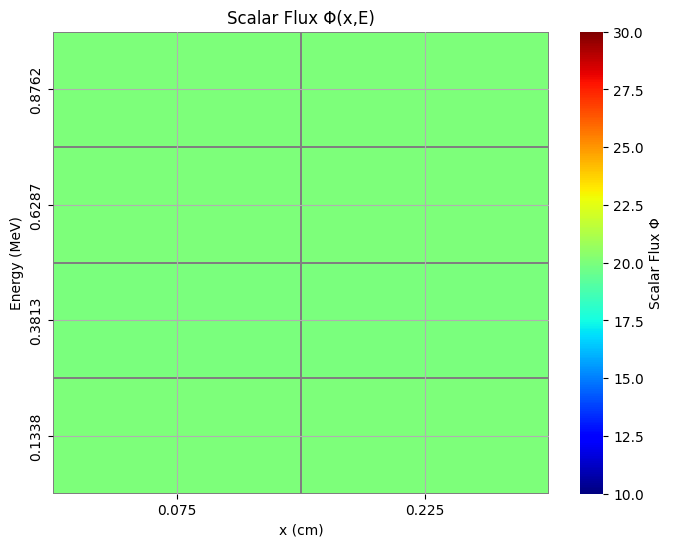

In [38]:
HeatMap = HeatmapPlot(phi, mesh, fes)
HeatMap.plot_heatmap(x_start, x_end, nx, E_start, E_end, nE, vmin = 10, vmax = 30)

In [39]:
glvis((mesh, phi), 1200, 1200)

_GlvisWidgetCore(data_str='solution\nMFEM mesh v1.0\n\n#\n# MFEM Geometry Types (see fem/geom.hpp):\n#\n# POIN…